<a href="https://colab.research.google.com/github/DaryaVish/first-project/blob/main/Mathcing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Мэтчинг товаров**

Задача:

* Разработать алгоритм, который каждый поступающий запрос преобразует в векторное представление эмбеддинг;
*  рассчитать расстояния между полученным эмбеддингом запроса и эмбеддингами всех документов, лежащих в индексе;
* оценить качество алгоритма по метрике accuracy@5 - для каждого товара подобрать 5 ближайших соседей  - несколько вариантов наиболее похожих товаров.



In [ ]:
!pip install sklearn -q
!pip install tqdm -q
!pip install progressbar2 -q
!apt install libomp-dev -q
!pip install faiss-gpu -q

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libomp-14-dev libomp5-14
Suggested packages:
  libomp-14-doc
The following NEW packages will be installed:
  libomp-14-dev libomp-dev libomp5-14
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 738 kB of archives.
After this operation, 8,991 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64

In [ ]:
import pandas as pd
import numpy as np
import faiss
import scipy.linalg
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from IPython.display import display, HTML
import warnings


from sklearn.preprocessing import (
    StandardScaler
)


pd.set_option('display.max_columns', 74)
warnings.filterwarnings("ignore")


RANDOM_STATE = 42

In [ ]:
%%time
train = pd.read_csv('https://drive.usercontent.google.com/u/0/uc?id=1qQhCHWZwOu58y8eXm-SoCug0hkEE4zbu&export=download', index_col = 'Id')
validation_answer = pd.read_csv('https://drive.usercontent.google.com/u/0/uc?id=1Ez0CKaYeR3pqWFZzUt1kGh74gecvk-t4&export=download', index_col = 'Id')
validation = pd.read_csv('https://drive.usercontent.google.com/download?id=1iA6NPktRrjcJg9qFOzsNBwQfklOu-6V7&export=download&authuser=0&confirm=t&uuid=8d2bdd9b-1f62-4b58-a395-f119647cf44d&at=APZUnTVIvIcGUN8OXZDRovIkKDR8:1724204967509', index_col = 'Id')
base = pd.read_csv('https://drive.usercontent.google.com/download?id=1-FVxNENeXs965IBdmQFiUUZEQmnCiU_K&export=download&authuser=0&confirm=t&uuid=bbcba3b0-3bc6-4fa8-b724-99e6f153c346&at=APZUnTXhzQeg2mPlaYi9loChRDhP:1721096580358', index_col = 'Id')

CPU times: user 5.62 s, sys: 974 ms, total: 6.59 s
Wall time: 32.7 s


Загрузим данные и объединим их в словарь, чтобы избежать дублирования кода

In [ ]:
sets = {'train': train, 'validation': validation, 'base': base}
def show_name(name):
    display(HTML('<h3>' + name + '<h3>'))

In [ ]:
for name in sets:
    df = sets[name]
    show_name(name)
    display(df.shape)

(9999, 73)

(10000, 72)

(291813, 72)

In [ ]:
validation_answer.shape

(10000, 1)

*   train состоит из 9999 объектов и 73 признаков
*   validation состоит из 10000 объектов и 72 признаков
*   base состоит из 291813 объектов и 72 признаков
*   validation_answer состоит из 10000 объектов и одного целевого признака - разметки для validation





In [ ]:
for name in sets:
    df = sets[name]
    show_name(name)
    display(df.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109249-query,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.903130,-759.626065,-75.284454,120.55149,131.131700,-149.211060,-102.31221,21.387623,11.277594,143.22140,-22.011570,-3.618249,-16.005480,-133.38228,-78.89356,-65.690530,407.773575,-11.660624,67.008150,24.975033,813.770071,40.051064,17.933155,-75.435745,149.81720,-23.413877,-178.095570,133.786470,-906.571061,113.355560,83.942260,-16.592659,-146.52074,-120.237860,-27.341612,-8.845615,1.027612,-175.647720,167.735820,-32.931559,47.860960,-196.247500,-118.81005,-4.762772,-114.877680,37.397278,-55.616966,56.627056,-108.43317,87.372560,76.513430,-136.27057,3.652915,-164.574510,-635.284275,-75.647255,-116.679340,-41.234684,-24.601670,-167.760770,133.678516,68.184600,26.317545,11.938202,148.549320,-778.563381,-46.877750,66971-base
34137-query,-82.033580,8.115866,-8.793022,-182.972100,56.645336,-52.597610,-55.720337,130.059250,129.38335,76.202880,-137.799420,33.30165,-2.868191,-34.318770,189.06479,-19.337550,-14.208210,-71.110245,-157.74814,-78.70069,-91.741875,1054.205600,-41.845630,102.128620,72.559050,813.770071,-37.957787,17.598982,-159.975400,140.02528,-8.819328,-147.055180,113.819870,-529.295053,70.674940,55.976795,8.817799,-134.14812,-73.679794,-57.566544,-4.338496,-3.270682,-144.499200,144.650200,-37.903276,58.913525,-105.362840,-125.66783,19.367283,-29.087658,-35.021350,26.627962,55.718437,-110.52611,83.513374,75.926130,-135.68242,-7.429803,-180.645020,11.470171,16.464691,-121.807236,-90.814450,54.448433,-120.894806,-12.292085,66.608116,-27.997612,10.091335,95.809265,-1022.691531,-88.564705,1433819-base
136121-query,-75.719640,-0.223386,-86.186130,-162.064060,114.320114,-53.394600,-117.261013,-24.857851,124.80780,112.190155,-200.925960,-38.86518,-80.611270,14.343805,156.62129,-22.498169,-26.359468,-109.034870,-106.92659,-79.74731,-69.876830,1507.231274,-20.058287,34.334927,23.592144,813.770071,-49.503860,22.166200,-85.740160,134.83647,-69.569850,-139.887240,67.377045,-341.781842,54.161224,81.891660,36.421352,-159.99583,-131.916080,-20.495195,-13.976569,-2.355247,-216.228650,238.836490,-56.611536,43.366640,7.191841,-159.48369,-19.338009,-51.409897,36.819540,32.536880,80.681020,-232.40741,84.053690,59.086180,-139.85950,78.409440,-115.940575,2.426572,7.594826,-126.520134,-73.148960,-5.609123,-93.029880,-80.997871,63.733383,11.378683,62.932007,130.975390,-1074.464888,-74.861176,290133-base
105191-query,-56.580620,5.093593,-46.943110,-149.039120,112.436430,-76.820510,-324.995645,-32.833107,119.47865,120.074790,-61.347084,-28.67060,-102.790180,-36.194320,157.18976,-33.318240,7.448413,-47.230713,-178.04608,-78.78652,-106.235440,1507.231274,-63.414307,38.099255,-89.795350,813.770071,-107.432390,10.052701,-71.917380,147.74005,-18.750763,-143.795620,67.207310,-366.139446,112.187700,78.144810,-41.085410,-132.75719,-89.445030,-19.267069,-14.866466,7.775788,-104.302110,74.622894,-59.875136,76.406470,-77.797020,-92.01658,19.337300,-37.922787,37.271270,111.639570,94.912950,-179.72540,86.601480,62.698364,-122.16293,29.873940,-53.508120,-0.938894,-36.919907,-144.555000,-96.798590,21.624313,-158.880370,179.597294,69.891360,-33.804955,233.914610,122.868546,-1074.464888,-93.775375,1270048-base
63983-query,-52.725650,9.027046,-92.829650,-113.111010,134.124970,-42.423073,-759.626065,8.261169,119.49023,172.365360,-186.641390,-84.94380,-92.339966,-30.229528,167.86163,-22.635653,0.014536,-9.796367,-213.10180,-78.59006,-98.728300,1250.423749,-43.892487,86.288450,-1.549826,813.770071,-110.356980,24.055641,-96.578270,156.58230,45.124240,-123.888504,118.035110,-607.946912,52.311410,76.747800,-14.161914,-143.53851,-124.886215,-64.783330,-17.706848,15.446568,-53.554455,174.381620,-23.140892,76.419330,-73.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
196680-query,-59.383420,8.563436,-28.203072,-134.22534,82.73661,-150.572170,-129.178969,23.670555,125.66636,108.809586,-129.48387,-178.983060,-109.600174,-8.799808,172.95998,-20.794373,-30.065893,-14.889741,-213.47429,-81.442860,-92.558720,1507.231274,96.508420,87.975250,55.862797,813.770071,1.647972,16.160482,-77.401474,166.08685,-7.085945,-114.40581,116.564270,-481.586956,40.185913,73.085365,-37.582203,-140.10822,-113.26041,-64.863230,-16.001427,7.223721,-5.791832,154.656310,-34.690983,52.748238,-34.976818,-160.459520,-28.526081,11.436787,107.386640,33.117570,56.67899,-43.842407,95.18327,51.950043,-123.31064,-10.645209,-52.291348,-525.623407,53.718872,-129.388460,-103.481630,79.564530,-120.31357,54.218155,68.50073,32.681908,84.19686,136.412960,-1074.464888,-21.233612
134615-query,-103.912150,9.742726,-15.209915,-116.37310,137.69880,-85.530075,-776.123158,44.481530,114.67121,95.231290,-166.03618,-66.359830,-36.001366,3.264235,73.06930,-29.384926,22.245693,62.498410,-114.18031,-80.017426,-56.034016,914.812090,-23.072426,64.591540,47.074090,813.770071,1.761437,24.459257,-177.638370,157.88023,-15.648800,-174.11716,37.697598,-701.605866,18.383450,81.502020,22.231460,-129.41878,-117.69812,-53.364460,-4.394635,11.108950,-109.880050,102.263280,-47.268603,52.336370,31.617912,13.088348,0.388435,-55.594444,-37.935482,-46.970780,50.48210,-132.518330,88.67881,81.240204,-130.75761,4.710941,-114.013050,-433.616738,-119.455990,-129.188340,-51.193770,49.299644,-101.89454,105.560548,67.80104,13.633057,108.05138,111.864456,-841.022331,-76.567980
82675-query,-117.923280,-3.504554,-64.299390,-155.18713,156.82137,-34.082264,-537.423653,54.078613,121.97396,59.321335,-90.08289,4.986931,-52.514560,52.529945,140.47353,-4.860558,-18.063830,-36.537400,-137.92374,-79.661070,-70.733120,1507.231274,-7.057582,26.213560,-2.779066,813.770071,-69.704410,16.080505,-90.432610,137.94106,24.971474,-138.86641,92.287190,-735.671365,68.335190,78.208220,14.043610,-147.51697,-113.89963,-18.748684,-8.779379,-8.737224,-177.382870,156.102450,-35.756027,65.317690,-262.907840,-96.018070,55.713432,22.165249,151.100540,-24.815138,70.92110,-121.119310,91.86982,87.153366,-138.07550,-3.309690,14.035965,-107.596636,-152.853940,-118.997840,-115.176155,48.636130,-132.17967,-0.988696,68.11125,107.065216,134.61765,134.080000,27.773269,-32.401714
162076-query,-90.880554,4.888542,-39.647797,-131.75010,62.36212,-105.593270,-347.132493,-83.351750,133.91331,201.146090,-193.19345,-31.961876,-11.191006,-28.481222,157.13997,-39.513940,-20.431585,30.671173,-131.63226,-79.841600,-74.222690,1507.231274,-75.135840,34.678430,-14.997078,401.379624,-29.014805,17.788988,-87.424790,160.81638,-13.624538,-137.01877,89.403885,-388.662473,-0.446587,73.493530,3.995680,-144.55515,-125.87352,-35.733467,-9.979044,2.092319,-114.457405,158.609240,-58.275016,96.416830,-166.106690,-36.610770,95.944460,-43.662690,33.869110,30.895940,65.87759,-106.503220,94.52601,72.289566,-152.20987,29.090012,-188.342150,-327.117943,43.212470,-139.852200,-112.293790,54.884007,-177.56935,-116.374997,67.88766,136.893980,124.89447,117.707750,-566.343980,-90.905556
23069-query,-66.946740,10.562773,-73.781830,-149.39787,2.93866,-51.288853,-587.189361,-2.764402,126.56105,131.900620,-131.93640,-35.794685,-155.979580,-2.110109,137.72418,-11.544052,-12.957520,2.028175,-129.12962,-79.461266,-72.883120,1507.231274,-47.112600,7.837235,-8.623394,813.770071,-60.251694,11.591301,-82.794800,134.84439,4.764982,-114.47928,83.150400,-156.249890,41.852833,42.160450,-58.565960,-146.39613,-90.59503,-53.295376,-12.213371,-8.682546,-142.693270,71.629135,-57.668621,55.122387,10.182793,-100.190810,-45.052837,-46.877544,10.418076,106.135445,75.15257,-110.051500,83.05377,97.87521

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4207931-base,-43.946243,15.364378,17.515854,-132.31146,157.064420,-4.069252,-340.630860,-57.550140,128.398220,45.090958,-126.84374,4.494522,-99.842310,44.926903,177.52173,-12.291790,38.470360,105.357650,-142.46024,-80.163260,-110.368935,1047.517357,-69.594620,66.313540,84.873870,813.770071,-81.038780,16.162964,-98.244880,159.53406,27.554913,-209.184280,62.05977,-529.295053,114.598330,90.469894,-20.256914,-164.76800,-133.31387,-41.252960,-10.251193,8.289038,-131.312710,75.704500,-16.483078,40.771038,-146.096740,-143.407680,49.807987,63.434480,-30.250080,20.470263,78.079910,-128.915310,92.327680,63.885570,-141.17464,142.902590,-93.068596,-568.421584,-90.018690,-129.015670,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.98834,-1074.464888,-25.066608
2710972-base,-73.004890,4.923342,-19.750746,-136.52908,99.907170,-70.709110,-567.401996,-128.890150,109.914986,201.472200,-186.22650,29.896042,-99.770996,0.126302,136.19049,-35.224740,-30.321323,-43.148834,-162.85175,-79.714510,-75.784870,1507.231274,-69.654564,43.640663,-4.779669,813.770071,43.976913,11.924875,-50.228523,166.00820,-59.505333,-115.332520,72.18324,-735.671365,96.322300,85.796360,-22.030330,-147.54501,-108.38295,-45.084892,-15.004004,-1.532826,-46.456585,197.578950,-56.199876,60.298710,-102.653340,-108.967964,58.512012,-9.678028,-85.448300,-68.686080,71.590200,-232.425690,91.706856,63.290657,-137.33595,-47.124687,-148.057400,-543.787056,-160.651600,-133.462220,-109.044660,20.916021,-171.201390,-110.596844,67.730100,8.909615,-9.470253,133.29536,-545.897014,-72.913230
1371460-base,-85.565570,-0.493598,-48.374817,-157.98502,96.809510,-81.710210,-22.297688,79.768670,124.357086,105.715180,-149.80756,-54.501680,-21.037973,-24.887660,128.38864,-58.558483,34.862656,19.784412,-130.91820,-79.032230,-166.635250,1507.231274,-8.495993,61.205086,25.895348,813.770071,-140.768860,20.872790,-123.957570,126.34781,11.713674,-125.025154,152.68590,-1018.469545,-22.444600,73.897640,9.190645,-156.51881,-92.18573,-34.926760,-13.277475,16.026424,-33.853546,119.604520,-52.525341,71.204750,-178.702940,-88.278500,30.501453,16.651737,-88.377014,-55.883583,70.182980,-89.233925,92.005780,76.458725,-131.14087,40.914352,-157.900540,-394.319235,-87.107025,-120.772545,-58.821650,41.369606,-132.934500,-43.016839,67.871925,141.778240,69.048520,111.72038,-1111.038833,-23.087206
3438601-base,-105.564090,15.393871,-46.223934,-158.11488,79.514114,-48.944480,-93.713010,38.581398,123.397960,110.324326,-161.18800,-68.519790,-0.607330,38.733696,120.74344,-14.109269,28.868027,-29.858810,-94.30395,-79.339810,-138.984270,1507.231274,-131.885380,70.031360,32.736595,813.770071,-62.370860,13.763219,-31.872276,139.55270,9.836465,-150.221130,80.14020,-537.183707,3.091667,129.699330,-63.429424,-169.02724,-119.77007,-28.637785,-8.315162,2.752385,-160.293820,85.086890,-18.251750,90.374054,1.479935,-121.983050,65.852660,8.355225,34.118896,-57.069756,70.461800,-127.905410,94.314280,71.259940,-135.57787,-39.982346,-159.751560,-230.147648,-95.221160,-148.814090,-87.907290,-58.806870,-147.794800,-155.830237,68.974754,21.397510,126.098785,139.73320,-1282.707248,-74.527940
422798-base,-74.638880,11.315012,-40.204174,-161.76430,50.507114,-80.775560,-640.923467,65.225000,122.344940,191.465850,-156.98384,-76.650210,-75.674970,12.624029,145.33752,-35.774258,11.598761,-11.460761,-201.35443,-77.779366,-120.968400,548.736883,19.851685,17.943344,27.063320,813.770071,-85.483780,21.236433,-95.071020,132.61092,13.526038,-160.476840,104.71937,-304.174382,-15.385452,91.418655,-36.474556,-157.43959,-102.83162,-56.782710,-19.969252,-0.598189,-222.228790,33.441666,-56.092110,71.276030,-8.713509,-86.099380,8.488903,-14.959278,86.812996,-29.6

Датасеты содержат одинаковое количество признаков за исключением Target в train

In [ ]:
for name in sets:
    df = sets[name]
    show_name(name)
    display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 109249-query to 13504-query
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9999 non-null   float64
 1   1       9999 non-null   float64
 2   2       9999 non-null   float64
 3   3       9999 non-null   float64
 4   4       9999 non-null   float64
 5   5       9999 non-null   float64
 6   6       9999 non-null   float64
 7   7       9999 non-null   float64
 8   8       9999 non-null   float64
 9   9       9999 non-null   float64
 10  10      9999 non-null   float64
 11  11      9999 non-null   float64
 12  12      9999 non-null   float64
 13  13      9999 non-null   float64
 14  14      9999 non-null   float64
 15  15      9999 non-null   float64
 16  16      9999 non-null   float64
 17  17      9999 non-null   float64
 18  18      9999 non-null   float64
 19  19      9999 non-null   float64
 20  20      9999 non-null   float64
 21  21      9999 non-null   

None

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 196680-query to 43566-query
Data columns (total 72 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10000 non-null  float64
 1   1       10000 non-null  float64
 2   2       10000 non-null  float64
 3   3       10000 non-null  float64
 4   4       10000 non-null  float64
 5   5       10000 non-null  float64
 6   6       10000 non-null  float64
 7   7       10000 non-null  float64
 8   8       10000 non-null  float64
 9   9       10000 non-null  float64
 10  10      10000 non-null  float64
 11  11      10000 non-null  float64
 12  12      10000 non-null  float64
 13  13      10000 non-null  float64
 14  14      10000 non-null  float64
 15  15      10000 non-null  float64
 16  16      10000 non-null  float64
 17  17      10000 non-null  float64
 18  18      10000 non-null  float64
 19  19      10000 non-null  float64
 20  20      10000 non-null  float64
 21  21      10000 non-null 

None

<class 'pandas.core.frame.DataFrame'>
Index: 291813 entries, 4207931-base to 274130-base
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       291813 non-null  float64
 1   1       291813 non-null  float64
 2   2       291813 non-null  float64
 3   3       291813 non-null  float64
 4   4       291813 non-null  float64
 5   5       291813 non-null  float64
 6   6       291813 non-null  float64
 7   7       291813 non-null  float64
 8   8       291813 non-null  float64
 9   9       291813 non-null  float64
 10  10      291813 non-null  float64
 11  11      291813 non-null  float64
 12  12      291813 non-null  float64
 13  13      291813 non-null  float64
 14  14      291813 non-null  float64
 15  15      291813 non-null  float64
 16  16      291813 non-null  float64
 17  17      291813 non-null  float64
 18  18      291813 non-null  float64
 19  19      291813 non-null  float64
 20  20      291813 non-null  float64
 21 

None

Объекты хранятся во float64 и не содержат пропусков или null

In [ ]:
for name in sets:
    df = sets[name]
    show_name(name)
    display(df.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109249-query,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.903130,-759.626065,-75.284454,120.55149,131.131700,-149.211060,-102.31221,21.387623,11.277594,143.22140,-22.011570,-3.618249,-16.005480,-133.38228,-78.89356,-65.690530,407.773575,-11.660624,67.008150,24.975033,813.770071,40.051064,17.933155,-75.435745,149.81720,-23.413877,-178.095570,133.786470,-906.571061,113.355560,83.942260,-16.592659,-146.52074,-120.237860,-27.341612,-8.845615,1.027612,-175.647720,167.735820,-32.931559,47.860960,-196.247500,-118.81005,-4.762772,-114.877680,37.397278,-55.616966,56.627056,-108.43317,87.372560,76.513430,-136.27057,3.652915,-164.574510,-635.284275,-75.647255,-116.679340,-41.234684,-24.601670,-167.760770,133.678516,68.184600,26.317545,11.938202,148.549320,-778.563381,-46.877750,66971-base
34137-query,-82.033580,8.115866,-8.793022,-182.972100,56.645336,-52.597610,-55.720337,130.059250,129.38335,76.202880,-137.799420,33.30165,-2.868191,-34.318770,189.06479,-19.337550,-14.208210,-71.110245,-157.74814,-78.70069,-91.741875,1054.205600,-41.845630,102.128620,72.559050,813.770071,-37.957787,17.598982,-159.975400,140.02528,-8.819328,-147.055180,113.819870,-529.295053,70.674940,55.976795,8.817799,-134.14812,-73.679794,-57.566544,-4.338496,-3.270682,-144.499200,144.650200,-37.903276,58.913525,-105.362840,-125.66783,19.367283,-29.087658,-35.021350,26.627962,55.718437,-110.52611,83.513374,75.926130,-135.68242,-7.429803,-180.645020,11.470171,16.464691,-121.807236,-90.814450,54.448433,-120.894806,-12.292085,66.608116,-27.997612,10.091335,95.809265,-1022.691531,-88.564705,1433819-base
136121-query,-75.719640,-0.223386,-86.186130,-162.064060,114.320114,-53.394600,-117.261013,-24.857851,124.80780,112.190155,-200.925960,-38.86518,-80.611270,14.343805,156.62129,-22.498169,-26.359468,-109.034870,-106.92659,-79.74731,-69.876830,1507.231274,-20.058287,34.334927,23.592144,813.770071,-49.503860,22.166200,-85.740160,134.83647,-69.569850,-139.887240,67.377045,-341.781842,54.161224,81.891660,36.421352,-159.99583,-131.916080,-20.495195,-13.976569,-2.355247,-216.228650,238.836490,-56.611536,43.366640,7.191841,-159.48369,-19.338009,-51.409897,36.819540,32.536880,80.681020,-232.40741,84.053690,59.086180,-139.85950,78.409440,-115.940575,2.426572,7.594826,-126.520134,-73.148960,-5.609123,-93.029880,-80.997871,63.733383,11.378683,62.932007,130.975390,-1074.464888,-74.861176,290133-base
105191-query,-56.580620,5.093593,-46.943110,-149.039120,112.436430,-76.820510,-324.995645,-32.833107,119.47865,120.074790,-61.347084,-28.67060,-102.790180,-36.194320,157.18976,-33.318240,7.448413,-47.230713,-178.04608,-78.78652,-106.235440,1507.231274,-63.414307,38.099255,-89.795350,813.770071,-107.432390,10.052701,-71.917380,147.74005,-18.750763,-143.795620,67.207310,-366.139446,112.187700,78.144810,-41.085410,-132.75719,-89.445030,-19.267069,-14.866466,7.775788,-104.302110,74.622894,-59.875136,76.406470,-77.797020,-92.01658,19.337300,-37.922787,37.271270,111.639570,94.912950,-179.72540,86.601480,62.698364,-122.16293,29.873940,-53.508120,-0.938894,-36.919907,-144.555000,-96.798590,21.624313,-158.880370,179.597294,69.891360,-33.804955,233.914610,122.868546,-1074.464888,-93.775375,1270048-base
63983-query,-52.725650,9.027046,-92.829650,-113.111010,134.124970,-42.423073,-759.626065,8.261169,119.49023,172.365360,-186.641390,-84.94380,-92.339966,-30.229528,167.86163,-22.635653,0.014536,-9.796367,-213.10180,-78.59006,-98.728300,1250.423749,-43.892487,86.288450,-1.549826,813.770071,-110.356980,24.055641,-96.578270,156.58230,45.124240,-123.888504,118.035110,-607.946912,52.311410,76.747800,-14.161914,-143.53851,-124.886215,-64.783330,-17.706848,15.446568,-53.554455,174.381620,-23.140892,76.419330,-73.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
196680-query,-59.383420,8.563436,-28.203072,-134.22534,82.73661,-150.572170,-129.178969,23.670555,125.66636,108.809586,-129.48387,-178.983060,-109.600174,-8.799808,172.95998,-20.794373,-30.065893,-14.889741,-213.47429,-81.442860,-92.558720,1507.231274,96.508420,87.975250,55.862797,813.770071,1.647972,16.160482,-77.401474,166.08685,-7.085945,-114.40581,116.564270,-481.586956,40.185913,73.085365,-37.582203,-140.10822,-113.26041,-64.863230,-16.001427,7.223721,-5.791832,154.656310,-34.690983,52.748238,-34.976818,-160.459520,-28.526081,11.436787,107.386640,33.117570,56.67899,-43.842407,95.18327,51.950043,-123.31064,-10.645209,-52.291348,-525.623407,53.718872,-129.388460,-103.481630,79.564530,-120.31357,54.218155,68.50073,32.681908,84.19686,136.412960,-1074.464888,-21.233612
134615-query,-103.912150,9.742726,-15.209915,-116.37310,137.69880,-85.530075,-776.123158,44.481530,114.67121,95.231290,-166.03618,-66.359830,-36.001366,3.264235,73.06930,-29.384926,22.245693,62.498410,-114.18031,-80.017426,-56.034016,914.812090,-23.072426,64.591540,47.074090,813.770071,1.761437,24.459257,-177.638370,157.88023,-15.648800,-174.11716,37.697598,-701.605866,18.383450,81.502020,22.231460,-129.41878,-117.69812,-53.364460,-4.394635,11.108950,-109.880050,102.263280,-47.268603,52.336370,31.617912,13.088348,0.388435,-55.594444,-37.935482,-46.970780,50.48210,-132.518330,88.67881,81.240204,-130.75761,4.710941,-114.013050,-433.616738,-119.455990,-129.188340,-51.193770,49.299644,-101.89454,105.560548,67.80104,13.633057,108.05138,111.864456,-841.022331,-76.567980
82675-query,-117.923280,-3.504554,-64.299390,-155.18713,156.82137,-34.082264,-537.423653,54.078613,121.97396,59.321335,-90.08289,4.986931,-52.514560,52.529945,140.47353,-4.860558,-18.063830,-36.537400,-137.92374,-79.661070,-70.733120,1507.231274,-7.057582,26.213560,-2.779066,813.770071,-69.704410,16.080505,-90.432610,137.94106,24.971474,-138.86641,92.287190,-735.671365,68.335190,78.208220,14.043610,-147.51697,-113.89963,-18.748684,-8.779379,-8.737224,-177.382870,156.102450,-35.756027,65.317690,-262.907840,-96.018070,55.713432,22.165249,151.100540,-24.815138,70.92110,-121.119310,91.86982,87.153366,-138.07550,-3.309690,14.035965,-107.596636,-152.853940,-118.997840,-115.176155,48.636130,-132.17967,-0.988696,68.11125,107.065216,134.61765,134.080000,27.773269,-32.401714
162076-query,-90.880554,4.888542,-39.647797,-131.75010,62.36212,-105.593270,-347.132493,-83.351750,133.91331,201.146090,-193.19345,-31.961876,-11.191006,-28.481222,157.13997,-39.513940,-20.431585,30.671173,-131.63226,-79.841600,-74.222690,1507.231274,-75.135840,34.678430,-14.997078,401.379624,-29.014805,17.788988,-87.424790,160.81638,-13.624538,-137.01877,89.403885,-388.662473,-0.446587,73.493530,3.995680,-144.55515,-125.87352,-35.733467,-9.979044,2.092319,-114.457405,158.609240,-58.275016,96.416830,-166.106690,-36.610770,95.944460,-43.662690,33.869110,30.895940,65.87759,-106.503220,94.52601,72.289566,-152.20987,29.090012,-188.342150,-327.117943,43.212470,-139.852200,-112.293790,54.884007,-177.56935,-116.374997,67.88766,136.893980,124.89447,117.707750,-566.343980,-90.905556
23069-query,-66.946740,10.562773,-73.781830,-149.39787,2.93866,-51.288853,-587.189361,-2.764402,126.56105,131.900620,-131.93640,-35.794685,-155.979580,-2.110109,137.72418,-11.544052,-12.957520,2.028175,-129.12962,-79.461266,-72.883120,1507.231274,-47.112600,7.837235,-8.623394,813.770071,-60.251694,11.591301,-82.794800,134.84439,4.764982,-114.47928,83.150400,-156.249890,41.852833,42.160450,-58.565960,-146.39613,-90.59503,-53.295376,-12.213371,-8.682546,-142.693270,71.629135,-57.668621,55.122387,10.182793,-100.190810,-45.052837,-46.877544,10.418076,106.135445,75.15257,-110.051500,83.05377,97.87521

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4207931-base,-43.946243,15.364378,17.515854,-132.31146,157.064420,-4.069252,-340.630860,-57.550140,128.398220,45.090958,-126.84374,4.494522,-99.842310,44.926903,177.52173,-12.291790,38.470360,105.357650,-142.46024,-80.163260,-110.368935,1047.517357,-69.594620,66.313540,84.873870,813.770071,-81.038780,16.162964,-98.244880,159.53406,27.554913,-209.184280,62.05977,-529.295053,114.598330,90.469894,-20.256914,-164.76800,-133.31387,-41.252960,-10.251193,8.289038,-131.312710,75.704500,-16.483078,40.771038,-146.096740,-143.407680,49.807987,63.434480,-30.250080,20.470263,78.079910,-128.915310,92.327680,63.885570,-141.17464,142.902590,-93.068596,-568.421584,-90.018690,-129.015670,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.98834,-1074.464888,-25.066608
2710972-base,-73.004890,4.923342,-19.750746,-136.52908,99.907170,-70.709110,-567.401996,-128.890150,109.914986,201.472200,-186.22650,29.896042,-99.770996,0.126302,136.19049,-35.224740,-30.321323,-43.148834,-162.85175,-79.714510,-75.784870,1507.231274,-69.654564,43.640663,-4.779669,813.770071,43.976913,11.924875,-50.228523,166.00820,-59.505333,-115.332520,72.18324,-735.671365,96.322300,85.796360,-22.030330,-147.54501,-108.38295,-45.084892,-15.004004,-1.532826,-46.456585,197.578950,-56.199876,60.298710,-102.653340,-108.967964,58.512012,-9.678028,-85.448300,-68.686080,71.590200,-232.425690,91.706856,63.290657,-137.33595,-47.124687,-148.057400,-543.787056,-160.651600,-133.462220,-109.044660,20.916021,-171.201390,-110.596844,67.730100,8.909615,-9.470253,133.29536,-545.897014,-72.913230
1371460-base,-85.565570,-0.493598,-48.374817,-157.98502,96.809510,-81.710210,-22.297688,79.768670,124.357086,105.715180,-149.80756,-54.501680,-21.037973,-24.887660,128.38864,-58.558483,34.862656,19.784412,-130.91820,-79.032230,-166.635250,1507.231274,-8.495993,61.205086,25.895348,813.770071,-140.768860,20.872790,-123.957570,126.34781,11.713674,-125.025154,152.68590,-1018.469545,-22.444600,73.897640,9.190645,-156.51881,-92.18573,-34.926760,-13.277475,16.026424,-33.853546,119.604520,-52.525341,71.204750,-178.702940,-88.278500,30.501453,16.651737,-88.377014,-55.883583,70.182980,-89.233925,92.005780,76.458725,-131.14087,40.914352,-157.900540,-394.319235,-87.107025,-120.772545,-58.821650,41.369606,-132.934500,-43.016839,67.871925,141.778240,69.048520,111.72038,-1111.038833,-23.087206
3438601-base,-105.564090,15.393871,-46.223934,-158.11488,79.514114,-48.944480,-93.713010,38.581398,123.397960,110.324326,-161.18800,-68.519790,-0.607330,38.733696,120.74344,-14.109269,28.868027,-29.858810,-94.30395,-79.339810,-138.984270,1507.231274,-131.885380,70.031360,32.736595,813.770071,-62.370860,13.763219,-31.872276,139.55270,9.836465,-150.221130,80.14020,-537.183707,3.091667,129.699330,-63.429424,-169.02724,-119.77007,-28.637785,-8.315162,2.752385,-160.293820,85.086890,-18.251750,90.374054,1.479935,-121.983050,65.852660,8.355225,34.118896,-57.069756,70.461800,-127.905410,94.314280,71.259940,-135.57787,-39.982346,-159.751560,-230.147648,-95.221160,-148.814090,-87.907290,-58.806870,-147.794800,-155.830237,68.974754,21.397510,126.098785,139.73320,-1282.707248,-74.527940
422798-base,-74.638880,11.315012,-40.204174,-161.76430,50.507114,-80.775560,-640.923467,65.225000,122.344940,191.465850,-156.98384,-76.650210,-75.674970,12.624029,145.33752,-35.774258,11.598761,-11.460761,-201.35443,-77.779366,-120.968400,548.736883,19.851685,17.943344,27.063320,813.770071,-85.483780,21.236433,-95.071020,132.61092,13.526038,-160.476840,104.71937,-304.174382,-15.385452,91.418655,-36.474556,-157.43959,-102.83162,-56.782710,-19.969252,-0.598189,-222.228790,33.441666,-56.092110,71.276030,-8.713509,-86.099380,8.488903,-14.959278,86.812996,-29.6

Данные обезличены

Дубликаты

In [ ]:
for name in sets:
    df = sets[name]
    show_name(name)
    display(df.duplicated().sum())

243

265

11278

В base содержится 11278 дубликатов. Сложно решить судьбу дубликатов в обезличенном датасете товаров. Я думаю, что их нужно оставить, так как это могут быть например вещи с одинаковым ID, но разными размерами. В train и validation тоже есть дубликаты.

Ознакомимся с данными и взглянем на матрицу корреляций

In [ ]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)
for name in sets:
    df = sets[name]
    show_name(name)
    print(df.describe())

           0      1      2      3      4      5      6      7      8      9  \
count 9999.0 9999.0 9999.0 9999.0 9999.0 9999.0 9999.0 9999.0 9999.0 9999.0   
mean   -85.5    7.6  -43.9 -146.2  112.0  -73.7 -443.9   21.8  123.1  126.4   
std     26.0    5.0   39.3   20.3   47.6   28.7  281.5   66.5    6.4   64.9   
min   -173.0  -11.6 -187.3 -219.7  -71.2 -185.0 -791.4 -250.7   99.0 -113.1   
25%   -103.4    4.2  -70.0 -160.0   79.7  -93.6 -757.6  -21.3  118.8   82.0   
50%    -85.2    7.6  -43.0 -146.6  112.2  -74.0 -517.7   22.2  123.0  126.3   
75%    -67.4   11.0  -17.2 -132.7  144.1  -54.2 -203.4   66.4  127.5  170.0   
max      5.1   26.7  134.9  -71.2  297.4   31.4  109.6  261.4  145.2  353.2   

          10     11     12     13     14     15     16     17     18     19  \
count 9999.0 9999.0 9999.0 9999.0 9999.0 9999.0 9999.0 9999.0 9999.0 9999.0   
mean  -140.6  -69.3  -42.3    5.9  149.1  -23.9   -2.0  -13.3 -138.2  -79.2   
std     41.4   51.2   40.9   37.5   34.1   13.0   2

            0       1       2       3       4       5       6       7       8  \
count 10000.0 10000.0 10000.0 10000.0 10000.0 10000.0 10000.0 10000.0 10000.0   
mean    -85.3     7.6   -43.7  -146.0   111.2   -72.8  -440.6    21.8   123.1   
std      25.9     5.0    38.8    20.5    47.8    28.6   279.0    66.3     6.5   
min    -167.6   -10.6  -205.8  -219.7   -76.4  -170.9  -791.4  -278.0    97.4   
25%    -103.3     4.2   -69.6  -160.0    78.6   -92.4  -739.5   -22.1   118.6   
50%     -85.5     7.6   -43.2  -146.1   111.4   -72.7  -512.6    22.6   123.1   
75%     -67.2    11.0   -17.9  -132.0   143.6   -53.4  -204.5    67.2   127.6   
max      10.9    27.9   107.0   -73.9   287.4    47.0   109.4   251.1   146.0   

            9      10      11      12      13      14      15      16      17  \
count 10000.0 10000.0 10000.0 10000.0 10000.0 10000.0 10000.0 10000.0 10000.0   
mean    124.7  -141.5   -68.6   -41.7     6.6   148.1   -24.1    -2.2   -12.9   
std      65.5    42.2    51

             0        1        2        3        4        5        6        7  \
count 291813.0 291813.0 291813.0 291813.0 291813.0 291813.0 291813.0 291813.0   
mean     -86.3      8.1    -44.6   -146.6    111.3    -71.9   -393.4     20.4   
std       24.9      4.9     38.5     19.8     46.4     28.2    272.1     64.3   
min     -189.4    -12.6   -231.8   -224.9    -95.2   -188.5   -791.5   -296.2   
25%     -103.2      4.7    -69.5   -159.9     80.4    -91.2   -631.9    -22.1   
50%      -86.3      8.0    -43.8   -146.7    111.8    -71.8   -424.3     20.9   
75%      -69.3     11.5    -19.7   -133.3    142.4    -52.3   -157.3     64.0   
max       15.6     28.8    151.4    -55.2    299.3     49.9    109.6    301.1   

             8        9       10       11       12       13       14       15  \
count 291813.0 291813.0 291813.0 291813.0 291813.0 291813.0 291813.0 291813.0   
mean     123.7    124.4   -143.2    -69.9    -41.2      7.6    148.9    -23.2   
std        6.4     64.4    

* в train 6 (281.5), 21 (371.7), 25 (193.2), 33 (273.9), 59 (209.6) и 70 (405.7)
* в validation очень большое стандартное отклонение в признаках: 6 (279.2), 21 (371.5), 25 (193.2), 33 (273.8), 59 (211.1) и 70 (405.7)
* в base std очень большое в тех же признаках

CPU times: user 3.21 s, sys: 98.6 ms, total: 3.31 s
Wall time: 3.29 s


array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
        <Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
        <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>],
       [<Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
        <Axes: title={'center': '10'}>, <Axes: title={'center': '11'}>,
        <Axes: title={'center': '12'}>, <Axes: title={'center': '13'}>,
        <Axes: title={'center': '14'}>, <Axes: title={'center': '15'}>],
       [<Axes: title={'center': '16'}>, <Axes: title={'center': '17'}>,
        <Axes: title={'center': '18'}>, <Axes: title={'center': '19'}>,
        <Axes: title={'center': '20'}>, <Axes: title={'center': '21'}>,
        <Axes: title={'center': '22'}>, <Axes: title={'center': '23'}>],
       [<Axes: title={'center': '24'}>, <Axes: title={'center': '25'}>,
        <Axes: title={'center': '26'}>, <Axes: title={'center': '27'}>,

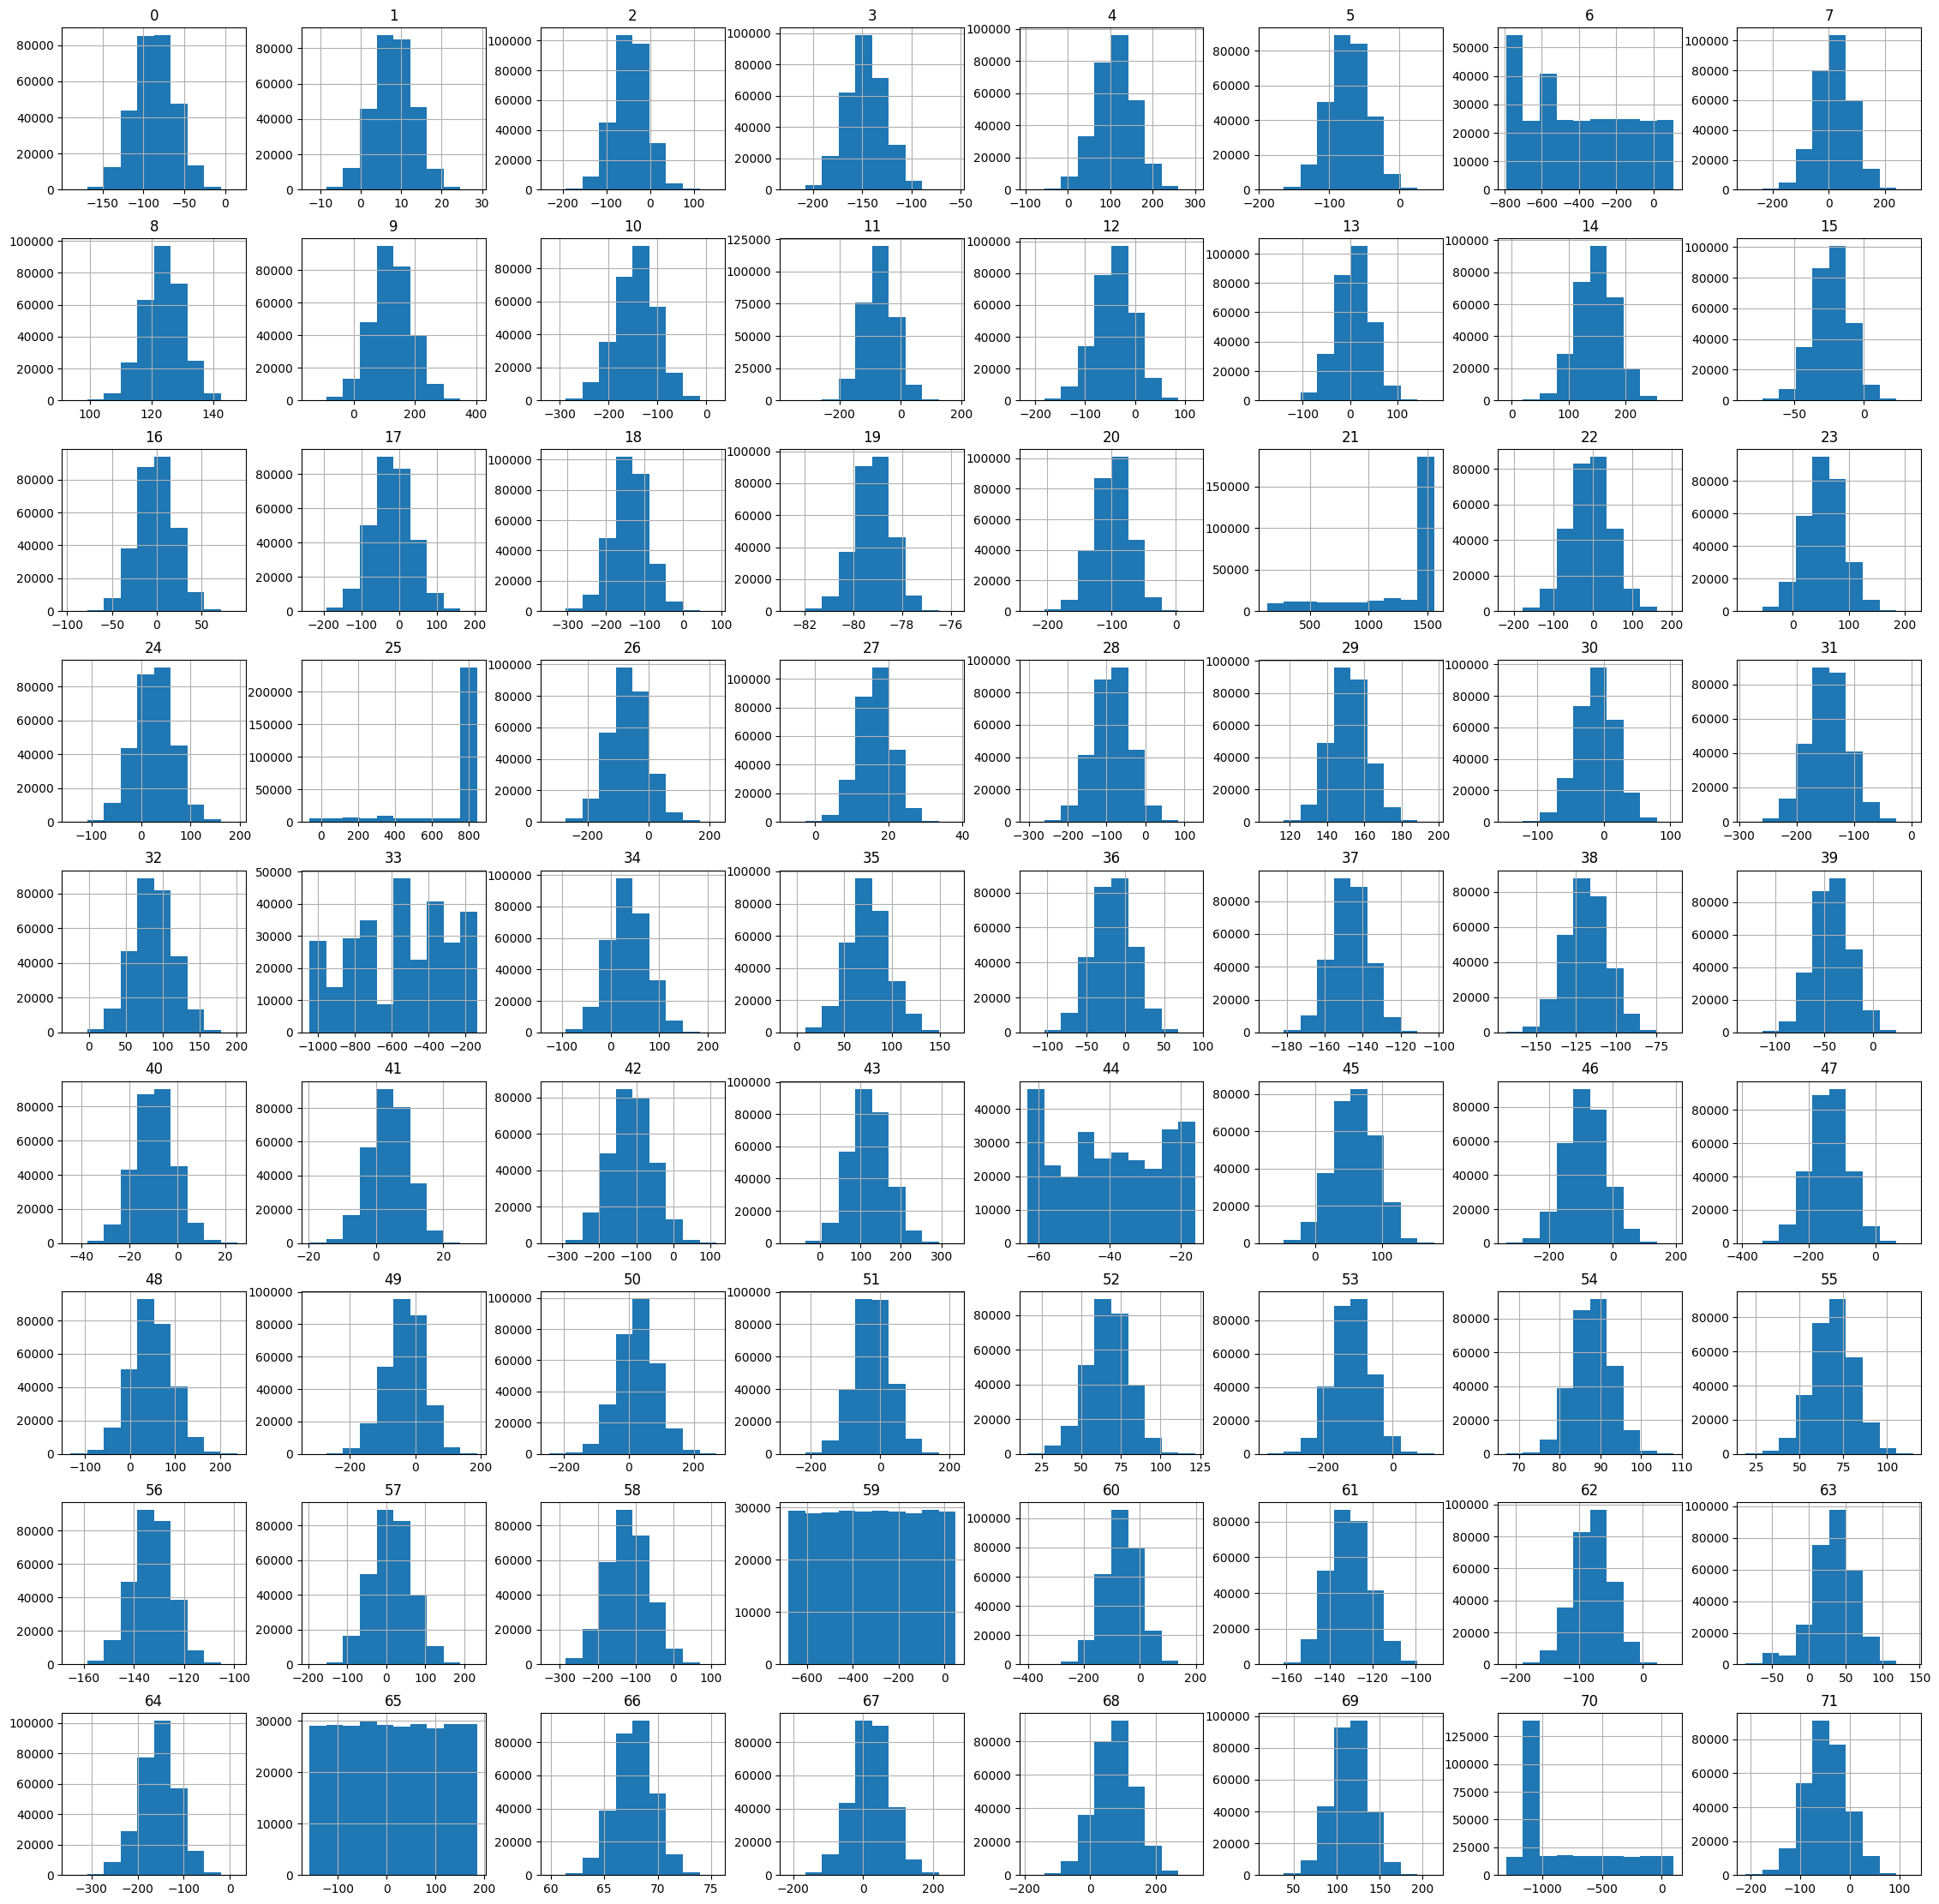

In [ ]:
%%time
base.hist(figsize=(28,28));

Большинство признаков имеет нормальное распределение, за исключением 6, 21, 25, 33, 44, 59, 65, 70. Думаю стоит их удалить, чтобы не путать модель.

По распределению видно еще один глючный столбец, которого не было заметно на describe - 44. Но не совсем понятно глючные это столбцы или категориальные на самом деле, так как данные закодированы сложно сделать выводы.

<Axes: >

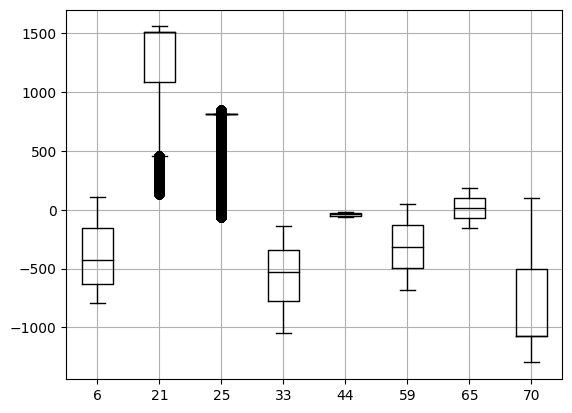

In [ ]:
base.boxplot(column=['6', '21', '25', '33', '44', '59', '65', '70'], grid=True , color='black')

По ящику с усами я бы сказала, что 6, 33, 59 и 65 признаки выглядят нормально без существенных выбросов.

In [ ]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette())

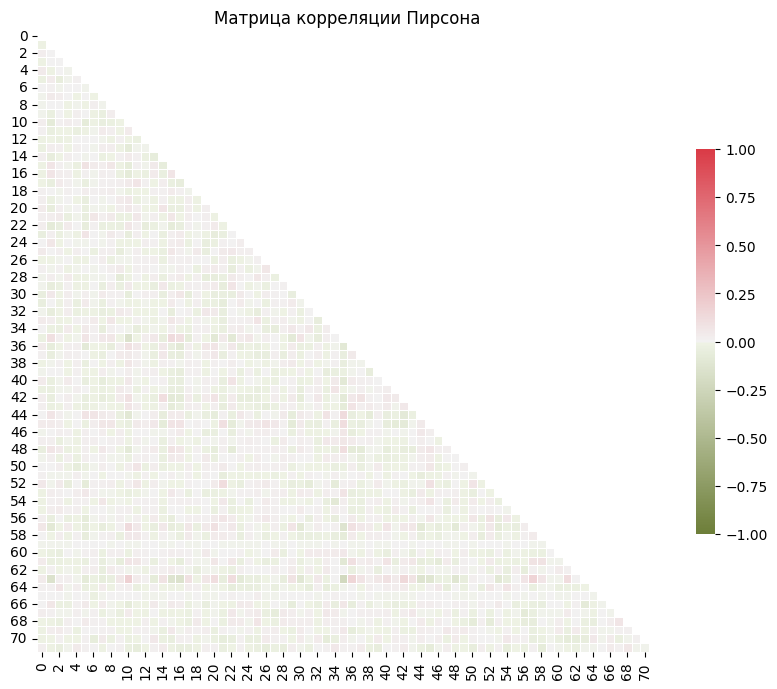

CPU times: user 9.1 s, sys: 128 ms, total: 9.22 s
Wall time: 9.09 s


In [ ]:
%%time
mask_corr = np.triu(np.ones_like(base.corr(numeric_only=True), dtype=bool))
cmap = sns.diverging_palette(100, 10, as_cmap=True)

plt.figure(figsize=(10,10))
sns.heatmap(base.corr(numeric_only=True), mask=mask_corr, cmap=cmap,
            vmax=1, vmin=-1, square=True, linewidths=.6, cbar_kws={'shrink': .5})

plt.title(f'Матрица корреляции Пирсона')
plt.show();

# Проведём преобразования необходимые для дальнейшей работы

Выделим target

In [ ]:
targets = train.Target
train = train.drop('Target', axis=1)

Оставим признаки только с нормальным распределением

In [ ]:
train_drop_feature = train.drop(columns=['6', '21', '25', '33', '44', '59', '65', '70'])
validation_drop_feature = validation.drop(columns=['6', '21', '25', '33', '44', '59', '65', '70'])

In [ ]:
base_drop_feature = base.drop(columns=['6', '21', '25', '33', '44', '59', '65', '70'])

Проверим выполнение кода и количество признков после преобразования

In [ ]:
print(f'Обучающая выборка {train_drop_feature.shape}')
print(f'Обучающая выборка {validation_drop_feature.shape}')
print(f'Тестовая выборка {base_drop_feature.shape}')

Обучающая выборка (9999, 64)
Обучающая выборка (10000, 64)
Тестовая выборка (291813, 64)


In [ ]:
display(validation)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
196680-query,-59.4,8.6,-28.2,-134.2,82.7,-150.6,-129.2,23.7,125.7,108.8,-129.5,-179.0,-109.6,-8.8,173.0,-20.8,-30.1,-14.9,-213.5,-81.4,-92.6,1507.2,96.5,88.0,55.9,813.8,1.6,16.2,-77.4,166.1,-7.1,-114.4,116.6,-481.6,40.2,73.1,-37.6,-140.1,-113.3,-64.9,-16.0,7.2,-5.8,154.7,-34.7,52.7,-35.0,-160.5,-28.5,11.4,107.4,33.1,56.7,-43.8,95.2,52.0,-123.3,-10.6,-52.3,-525.6,53.7,-129.4,-103.5,79.6,-120.3,54.2,68.5,32.7,84.2,136.4,-1074.5,-21.2
134615-query,-103.9,9.7,-15.2,-116.4,137.7,-85.5,-776.1,44.5,114.7,95.2,-166.0,-66.4,-36.0,3.3,73.1,-29.4,22.2,62.5,-114.2,-80.0,-56.0,914.8,-23.1,64.6,47.1,813.8,1.8,24.5,-177.6,157.9,-15.6,-174.1,37.7,-701.6,18.4,81.5,22.2,-129.4,-117.7,-53.4,-4.4,11.1,-109.9,102.3,-47.3,52.3,31.6,13.1,0.4,-55.6,-37.9,-47.0,50.5,-132.5,88.7,81.2,-130.8,4.7,-114.0,-433.6,-119.5,-129.2,-51.2,49.3,-101.9,105.6,67.8,13.6,108.1,111.9,-841.0,-76.6
82675-query,-117.9,-3.5,-64.3,-155.2,156.8,-34.1,-537.4,54.1,122.0,59.3,-90.1,5.0,-52.5,52.5,140.5,-4.9,-18.1,-36.5,-137.9,-79.7,-70.7,1507.2,-7.1,26.2,-2.8,813.8,-69.7,16.1,-90.4,137.9,25.0,-138.9,92.3,-735.7,68.3,78.2,14.0,-147.5,-113.9,-18.7,-8.8,-8.7,-177.4,156.1,-35.8,65.3,-262.9,-96.0,55.7,22.2,151.1,-24.8,70.9,-121.1,91.9,87.2,-138.1,-3.3,14.0,-107.6,-152.9,-119.0,-115.2,48.6,-132.2,-1.0,68.1,107.1,134.6,134.1,27.8,-32.4
162076-query,-90.9,4.9,-39.6,-131.8,62.4,-105.6,-347.1,-83.4,133.9,201.1,-193.2,-32.0,-11.2,-28.5,157.1,-39.5,-20.4,30.7,-131.6,-79.8,-74.2,1507.2,-75.1,34.7,-15.0,401.4,-29.0,17.8,-87.4,160.8,-13.6,-137.0,89.4,-388.7,-0.4,73.5,4.0,-144.6,-125.9,-35.7,-10.0,2.1,-114.5,158.6,-58.3,96.4,-166.1,-36.6,95.9,-43.7,33.9,30.9,65.9,-106.5,94.5,72.3,-152.2,29.1,-188.3,-327.1,43.2,-139.9,-112.3,54.9,-177.6,-116.4,67.9,136.9,124.9,117.7,-566.3,-90.9
23069-query,-66.9,10.6,-73.8,-149.4,2.9,-51.3,-587.2,-2.8,126.6,131.9,-131.9,-35.8,-156.0,-2.1,137.7,-11.5,-13.0,2.0,-129.1,-79.5,-72.9,1507.2,-47.1,7.8,-8.6,813.8,-60.3,11.6,-82.8,134.8,4.8,-114.5,83.2,-156.2,41.9,42.2,-58.6,-146.4,-90.6,-53.3,-12.2,-8.7,-142.7,71.6,-57.7,55.1,10.2,-100.2,-45.1,-46.9,10.4,106.1,75.2,-110.1,83.1,97.9,-135.8,11.6,-135.3,-336.4,19.9,-126.8,-116.4,47.3,-162.7,107.4,67.8,-61.0,142.7,82.3,-345.3,-48.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131936-query,-47.3,11.2,-23.2,-166.0,94.5,-87.9,-245.3,-42.4,116.7,77.2,-93.5,-49.6,-16.3,1.2,185.8,-19.0,-0.8,-62.0,-242.7,-78.0,-104.7,1507.2,27.7,89.2,-7.4,701.2,-132.1,19.5,-166.2,153.6,-14.1,-136.5,105.9,-972.4,29.4,70.6,2.0,-132.7,-87.5,-68.5,-12.6,4.9,-71.5,136.9,-55.6,87.7,-119.5,-189.9,61.4,-135.2,67.7,-10.4,72.9,-324.5,89.2,72.7,-126.4,-26.8,-157.1,-127.6,-53.8,-123.8,-122.3,71.2,-179.2,-85.5,66.0,50.0,66.5,137.1,-542.5,-57.0
175296-query,-90.1,5.3,-138.6,-117.9,61.0,-80.9,-429.3,-2.1,131.9,52.7,-105.1,-74.6,2.8,9.4,150.5,-27.3,31.9,-71.1,-39.4,-79.5,-59.0,194.2,-22.5,30.9,-0.9,813.8,-130.7,18.6,-137.5,145.3,-28.5,-174.3,52.1,-683.2,84.7,53.0,-16.9,-143.6,-113.9,1.6,-18.6,10.6,-182.7,130.3,-55.6,25.1,-6.0,-171.0,11.7,-75.2,72.0,85.3,95.6,-121.9,82.7,70.3,-133.3,13.9,-101.3,22.8,-26.5,-139.3,-34.0,46.8,-153.2,137.3,69.0,-18.3,62.3,85.6,-1296.6,-43.5
110795-query,-87.2,-1.9,-17.2,-143.7,104.1,-95.1,-759.6,46.0,113.4,94.3,-126.2,-104.3,-49.0,-10.8,188.7,-34.4,-4.0,-25.9,-138.2,-79.3,-82.6,464.6,-1.3,4.8,18.6,813.8,-76.6,15.6,-142.5,148.2,-17.8,-118.0,170.9,-406.4,42.7,89.6,-14.3,-121.4,-122.4,-48.6,9.1,0.7,-212.8,191.1,-41.7,2.7,-130.7,-129.8,16.5,-99.1,5.6,-49.7,56.7,-99.4,86.3,57.8,-129.6,48.5,-128.2,-328.8,-84.3,-128.1,-8

Теперь нужно сохранить уникальные Id товаров которые у нас записаны в индексе, иначе StandardScaler вернет свою индексацию начиная с 0.

In [ ]:
original_indices_X = train_drop_feature.index
original_indices_V = validation_drop_feature.index
original_indices_base = base_drop_feature.index
print(f'Индексы из train {original_indices_X}')
print(f'Индексы из validation {original_indices_V}')
print(f'Индексы из validation {original_indices_base}')

Индексы из train Index(['109249-query', '34137-query', '136121-query', '105191-query',
       '63983-query', '116555-query', '74517-query', '155040-query',
       '38525-query', '197875-query',
       ...
       '60738-query', '87810-query', '35558-query', '7826-query',
       '61722-query', '137428-query', '20333-query', '137225-query',
       '58874-query', '13504-query'],
      dtype='object', name='Id', length=9999)
Индексы из validation Index(['196680-query', '134615-query', '82675-query', '162076-query',
       '23069-query', '92948-query', '62999-query', '148892-query',
       '22907-query', '168970-query',
       ...
       '183696-query', '39762-query', '74030-query', '105723-query',
       '12789-query', '131936-query', '175296-query', '110795-query',
       '125640-query', '43566-query'],
      dtype='object', name='Id', length=10000)
Индексы из validation Index(['4207931-base', '2710972-base', '1371460-base', '3438601-base',
       '422798-base', '2318949-base', '1212693-ba

Масштабируем признаки и заменяем индексы на родные

In [ ]:
scaler = StandardScaler()

train_scaled = pd.DataFrame(scaler.fit_transform(train_drop_feature), columns = train_drop_feature.columns)

validation_scaled = pd.DataFrame(scaler.transform(validation_drop_feature), columns = validation_drop_feature.columns)
base_scaled = pd.DataFrame(scaler.transform(base_drop_feature), columns = base_drop_feature.columns)


train_scaled.index = original_indices_X
validation_scaled.index = original_indices_V
base_scaled.index = original_indices_base


display(train_scaled)
display(validation_scaled)
display(base_scaled)

,0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,60,61,62,63,64,66,67,68,69,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109249-query,2.4,-0.9,-0.9,1.7,1.7,0.2,-1.5,-0.4,0.1,-0.2,-0.6,1.6,0.1,-0.2,0.1,-0.1,-0.0,0.1,0.4,1.1,-0.2,0.3,0.0,1.7,0.3,0.2,-0.2,-0.3,-0.9,1.6,2.0,0.5,-0.1,0.0,-0.1,0.7,0.1,-0.5,-1.3,0.9,-0.4,-1.7,0.4,-1.1,-1.3,0.1,-0.6,-0.8,0.2,-0.2,0.6,-0.5,-0.2,-0.8,-0.1,1.5,1.3,-2.4,-0.4,0.2,0.0,-1.0,1.5,0.0
34137-query,0.1,0.1,0.9,-1.8,-1.2,0.7,1.6,1.0,-0.8,0.1,2.0,1.0,-1.1,1.2,0.4,-0.6,-1.1,-0.4,0.6,0.2,-0.8,1.3,1.2,0.4,0.3,-1.5,-1.2,0.2,-0.1,0.9,0.9,-0.9,0.9,1.2,3.3,-0.8,0.6,-1.3,-0.7,0.5,-0.0,-0.3,0.3,-0.6,0.1,-1.1,0.9,-0.9,0.2,-1.0,0.5,-0.4,-0.4,-1.1,1.3,0.9,-0.3,0.7,0.8,-0.6,-0.9,-1.0,-0.9,-1.0
136121-query,0.4,-1.6,-1.1,-0.8,0.0,0.7,-0.7,0.3,-0.2,-1.5,0.6,-0.9,0.2,0.2,0.1,-1.2,-1.7,0.6,-0.7,1.0,-0.3,-0.6,0.0,0.2,1.2,0.0,-1.7,-1.9,0.1,-0.8,0.5,0.4,2.0,-1.3,-1.0,1.0,-0.6,-1.1,-2.0,2.4,-0.5,1.4,-0.3,-1.4,-0.3,0.1,1.0,1.0,-2.0,-0.9,-0.8,-0.9,1.3,0.1,1.2,0.4,0.3,-1.7,1.4,-2.2,-0.2,-0.2,0.7,-0.6
105191-query,1.1,-0.5,-0.1,-0.1,0.0,-0.1,-0.8,-0.6,-0.1,1.9,0.8,-1.5,-1.1,0.2,-0.7,0.4,-0.6,-0.8,0.5,-0.3,-1.2,-0.5,-2.7,-0.7,-1.3,0.3,-0.4,-0.2,0.0,-0.8,1.9,0.3,-1.1,1.3,2.1,1.1,-0.7,0.6,0.0,-1.0,0.5,0.1,0.8,-0.6,-0.1,0.1,2.4,2.1,-1.1,-0.3,-0.5,1.3,0.3,1.2,0.5,-1.5,-0.5,-0.6,-0.2,1.1,-1.0,2.6,0.3,-1.1
63983-query,1.3,0.3,-1.2,1.6,0.5,1.1,-0.2,-0.6,0.7,-1.1,-0.3,-1.2,-1.0,0.6,0.1,0.1,0.1,-1.5,0.8,-0.0,-0.8,0.8,-0.6,-0.7,1.6,-0.2,0.4,2.0,0.6,1.0,0.4,0.2,-0.0,0.3,-0.5,-1.2,-1.0,1.9,0.9,1.1,0.5,0.2,0.2,-1.7,0.5,0.2,0.2,-0.4,0.4,-1.8,-1.6,0.2,-1.7,-2.6,0.4,0.3,-0.0,-0.9,-1.4,-0.7,0.3,1.5,-0.2,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137428-query,0.1,2.0,0.2,1.0,-0.5,1.4,-0.4,1.6,1.1,1.1,2.2,0.5,1.2,-0.4,-1.6,-0.9,-1.4,-0.7,0.1,-1.4,-0.1,1.7,-0.2,1.0,0.9,-0.7,-0.3,1.1,-0.7,0.4,-1.7,0.1,0.4,0.4,1.5,0.9,1.5,1.1,-0.2,-0.4,-0.3,0.5,0.2,0.0,1.7,-0.1,-0.4,1.6,-0.8,-0.9,0.8,0.8,-0.9,-1.9,-0.2,0.9,-0.0,-1.6,-0.2,-0.4,0.3,-0.3,-0.6,0.7
20333-query,-1.0,-0.3,0.0,0.3,-0.5,-0.3,-1.4,0.6,0.5,-0.5,0.3,-1.5,-0.6,0.3,-1.8,0.6,-0.7,0.5,1.1,-2.3,0.0,1.0,-1.3,0.8,1.6,-0.6,-0.4,0.8,-2.5,0.5,-0.4,0.1,0.5,1.0,0.8,-0.1,1.4,0.4,1.4,0.5,0.9,-2.1,1.4,-0.2,1.1,1.4,-0.2,2.3,-0.8,0.7,1.4,0.3,-0.3,0.6,-0.1,0.9,-0.2,-0.1,-1.8,-0.0,0.8,-0.6,1.5,1.1
137225-query,-1.4,0.3,-0.4,1.0,-0.3,0.1,0.7,-1.5,-0.6,1.0,1.2,-1.7,0.5,0.6,-0.7,-0.6,1.0,-0.9,2.1,0.3,-0.6,0.0,-0.4,0.1,1.2,-0.5,-2.1,0.2,-0.8,0.9,-0.0,-1.5,-0.3,-1.0,0.8,0.9,-0.6,1.8,0.9,-0.4,-1.2,1.9,-1.1,-0.9,0.7,-0.0,0.4,-0.5,0.7,-0.5,-1.0,-1.0,0.5,-2.6,-0.9,-0.3,1.3,-1.4,-0.8,0.5,-1.1,1.7,0.5,0.3


,0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,60,61,62,63,64,66,67,68,69,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
196680-query,1.0,0.2,0.4,0.6,-0.6,-2.7,0.0,0.4,-0.3,0.3,-2.1,-1.6,-0.4,0.7,0.2,-1.3,-0.0,-1.5,-2.9,0.2,2.0,0.9,0.8,1.0,-0.0,0.2,1.3,0.2,0.8,0.9,0.1,-0.0,-0.9,0.6,0.4,-1.2,-0.8,0.5,1.8,0.7,-0.2,0.7,-0.3,-1.6,0.8,1.3,1.0,-0.8,1.4,1.5,-1.4,1.2,-0.5,1.2,1.9,0.1,-0.7,1.7,0.8,0.4,0.2,0.2,1.0,0.7
134615-query,-0.7,0.4,0.7,1.5,0.5,-0.4,0.3,-1.3,-0.5,-0.6,0.1,0.2,-0.1,-2.2,-0.4,1.2,1.4,0.5,-1.1,1.5,-0.4,0.2,0.6,1.0,1.7,-1.9,0.6,-0.1,-0.8,-1.8,-0.5,0.4,1.4,1.7,0.0,-0.6,0.6,1.2,-0.1,-0.4,-0.2,1.7,2.6,-1.0,-0.4,-1.1,-0.4,-1.3,-0.2,0.1,0.9,0.2,-0.2,0.1,-0.8,0.1,1.0,0.5,1.2,-0.0,-0.2,0.6,-0.2,-0.7
82675-query,-1.2,-2.2,-0.5,-0.4,0.9,1.4,0.5,-0.2,-1.0,1.2,1.5,-0.2,1.2,-0.3,1.5,-0.8,-0.4,0.0,-0.6,0.9,-0.1,-0.9,-0.6,-0.1,-0.0,-0.1,-1.4,1.3,0.2,0.1,0.8,0.3,1.1,-0.1,0.3,1.1,0.1,-2.2,-1.3,0.7,0.2,-2.7,0.8,0.2,1.0,2.0,-0.0,0.3,-0.0,0.8,1.4,-0.7,-0.4,2.4,-1.3,1.2,-1.1,0.5,0.5,0.2,1.5,1.0,0.9,0.4
162076-query,-0.2,-0.5,0.1,0.7,-1.0,-1.1,-1.6,1.7,1.2,-1.3,0.7,0.8,-0.9,0.2,-1.2,-0.9,0.8,0.1,-0.9,0.8,-1.4,-0.6,-0.9,0.6,0.3,-0.0,0.8,0.0,0.2,-0.0,-0.9,0.0,0.7,0.2,-0.6,0.3,-0.1,-0.4,-0.2,0.8,1.2,-1.2,1.8,1.1,-0.2,0.1,1.0,-0.1,0.3,1.3,0.2,-2.5,0.3,-1.2,1.7,-1.0,-1.0,0.7,-0.6,0.0,2.1,0.8,0.1,-1.0
23069-query,0.7,0.6,-0.8,-0.2,-2.3,0.8,-0.4,0.5,0.1,0.2,0.7,-2.8,-0.2,-0.3,1.0,-0.5,0.3,0.2,-0.4,0.9,-0.9,-1.4,-0.8,0.1,-1.0,0.1,-1.7,0.6,0.8,-0.2,0.1,-1.6,-1.7,0.0,2.0,-0.6,-0.3,-2.2,-0.7,-1.0,-0.1,1.4,0.7,-2.0,-0.2,-0.3,2.3,0.6,0.2,-1.1,2.3,-0.4,-0.1,-0.3,1.3,0.4,-1.1,0.4,-0.2,-0.0,-1.5,1.1,-1.5,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131936-query,1.5,0.7,0.5,-1.0,-0.4,-0.5,-1.0,-1.0,-0.8,1.1,0.4,0.6,-0.1,1.1,0.4,0.1,-0.9,-2.1,1.5,-0.3,0.6,0.9,-0.7,-1.1,0.7,-1.6,0.1,-0.0,0.2,0.6,-0.2,-0.1,0.6,1.3,2.3,-1.4,-0.4,0.1,0.6,0.3,0.9,-0.5,-0.8,0.3,-1.7,0.6,0.2,0.4,-3.6,0.2,0.3,0.8,-0.8,-0.7,0.2,0.7,-1.3,1.3,-0.7,-1.0,0.5,-0.1,1.0,-0.2
175296-query,-0.2,-0.5,-2.4,1.4,-1.1,-0.3,-0.4,1.4,-1.1,0.9,-0.1,1.1,0.1,0.0,-0.3,1.6,-1.1,2.0,-0.4,1.4,-0.4,-0.7,-0.6,-1.0,0.5,-1.0,-0.7,-0.5,-0.8,-1.3,1.2,-1.0,-0.1,0.3,0.3,2.2,-1.1,1.1,-1.4,0.2,-1.1,1.2,-0.5,-0.7,-0.7,0.7,1.9,2.1,-0.0,-1.2,0.1,-0.1,-0.0,0.3,0.6,-0.9,1.5,0.4,-0.0,0.6,-0.8,-0.2,-1.4,0.1
110795-query,-0.1,-1.9,0.7,0.1,-0.2,-0.7,0.4,-1.5,-0.5,0.3,-0.7,-0.2,-0.4,1.2,-0.8,-0.1,-0.2,0.0,-0.1,0.5,0.0,-1.5,-0.1,-0.2,-0.1,-1.1,-0.4,-0.1,0.7,2.9,0.2,0.8,-0.0,2.5,-0.3,-0.4,2.2,-0.6,-1.9,1.4,-1.8,-0.7,0.2,-0.6,-1.1,-0.4,-0.5,-0.8,0.4,-0.4,-0.9,0.4,0.7,-0.1,-0.3,0.3,-0.2,-1.9,1.0,1.8,1.3,0.0,-0.8,-0.1


,0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,60,61,62,63,64,66,67,68,69,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4207931-base,1.6,1.6,1.6,0.7,0.9,2.4,-1.2,0.8,-1.3,0.3,1.4,-1.4,1.0,0.8,0.9,1.9,2.2,-0.1,-1.3,-0.5,-1.3,0.3,1.5,-0.3,-0.0,-0.2,0.7,1.4,-1.8,-1.0,2.0,0.9,-0.2,-1.8,-1.1,-0.0,-0.1,0.7,-0.5,-1.0,-0.6,-0.9,-0.0,0.1,1.6,-1.0,0.8,0.8,-0.1,0.9,-0.5,-1.1,2.6,0.5,-0.4,0.2,0.3,-0.3,1.5,-0.4,1.5,-1.9,1.9,0.6
2710972-base,0.5,-0.5,0.6,0.5,-0.3,0.1,-2.3,-2.1,1.2,-1.1,1.9,-1.4,-0.2,-0.4,-0.9,-1.4,-0.5,-0.5,-0.7,0.8,-1.3,-0.4,-0.7,1.7,-0.9,0.7,1.3,-1.6,0.8,-0.6,1.5,0.6,-0.3,-0.1,0.7,-0.2,-0.7,-1.0,1.0,1.6,0.0,-0.3,0.5,0.3,0.4,-1.9,-0.8,0.3,-2.0,0.7,-0.5,-0.6,-1.3,-0.5,-1.5,-0.3,-0.9,-0.6,-0.5,-0.0,-0.3,-1.3,0.8,-0.6
1371460-base,-0.0,-1.6,-0.1,-0.6,-0.3,-0.3,0.9,0.2,-0.3,-0.2,0.3,0.5,-0.8,-0.6,-2.7,1.8,0.6,0.1,0.2,-2.4,-0.1,0.1,0.1,-1.2,1.0,-0.8,-2.5,0.9,0.5,2.2,-1.5,0.0,0.9,-1.0,1.9,0.3,-0.5,2.0,1.3,-0.1,0.4,-1.4,0.9,-0.3,0.9,-2.0,-0.6,0.2,0.6,0.8,0.6,0.2,0.5,-0.7,-0.3,1.0,0.7,0.2,0.5,0.0,2.2,-0.1,-0.2,0.6
3438601-base,-0.8,1.6,-0.1,-0.6,-0.7,0.9,0.3,0.0,-0.2,-0.5,0.0,1.0,0.9,-0.8,0.8,1.5,-0.3,0.9,-0.2,-1.5,-2.6,0.4,0.2,0.0,-0.5,1.1,-1.2,0.8,-0.2,-0.3,-0.9,2.9,-1.9,-2.2,-0.1,0.6,0.1,-0.2,-1.0,-0.8,1.0,1.3,0.3,0.4,0.7,0.1,-0.6,0.2,-0.1,1.3,0.1,-0.4,-1.1,-0.7,-0.4,-2.0,-0.2,-3.8,0.1,0.6,-0.0,0.9,1.1,-0.6
422798-base,0.4,0.7,0.1,-0.8,-1.3,-0.2,0.7,-0.1,1.0,-0.4,-0.1,-0.8,0.2,-0.1,-0.9,0.6,0.0,-1.3,1.8,-0.8,0.5,-1.1,0.1,-0.3,1.0,-0.2,-1.9,0.9,-0.4,0.5,-1.3,0.9,-0.9,-1.1,1.1,-0.8,-1.3,-0.8,-2.1,-1.8,0.4,1.1,0.9,-0.8,0.3,0.9,-0.1,-0.2,1.1,-1.5,-0.0,-0.7,0.2,0.3,1.4,-0.1,1.7,0.7,0.1,0.9,-1.2,-2.2,0.9,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4392203-base,0.2,-0.6,0.8,-1.5,-0.2,0.6,0.5,-0.8,-1.3,-1.8,-0.4,0.9,2.4,1.0,1.0,-0.8,-1.3,0.3,0.8,0.2,-1.1,-1.4,0.4,-1.3,-1.4,-0.3,0.9,0.2,-1.4,0.4,-0.5,1.2,-0.3,-0.9,0.4,0.3,-0.6,1.2,1.3,0.6,0.6,0.2,-0.3,-0.8,-2.1,-0.8,-0.1,-0.7,-2.2,0.8,2.0,1.0,0.1,-1.3,0.2,1.6,0.2,0.5,-1.8,-0.5,-1.0,0.7,-0.2,-0.9
726601-base,0.5,-0.7,-0.7,-0.9,0.2,0.5,-0.3,-0.8,-0.9,0.6,-0.5,1.7,-0.9,1.4,-1.9,-1.6,1.4,0.2,1.7,0.7,-1.4,-0.4,-0.4,0.3,1.1,1.2,1.6,0.2,0.0,-1.0,-0.7,-1.0,0.9,-1.4,-0.3,1.9,-1.1,-1.4,1.1,0.0,0.9,-0.3,0.7,0.6,-1.1,0.4,-0.5,1.0,0.5,1.7,-0.5,-0.3,-1.1,-0.3,0.2,0.6,-0.6,0.2,-0.4,-0.6,0.6,0.0,1.6,2.4
2434660-base,-1.3,-1.1,-0.4,0.4,0.5,1.1,-0.8,0.8,0.1,-2.0,-0.2,-1.0,-0.9,-0.3,0.8,0.5,-0.1,0.0,0.2,0.9,0.8,0.4,-0.1,-0.1,-0.6,-0.5,-2.6,-0.4,1.2,-0.4,1.7,0.4,-0.5,0.8,-0.7,-1.9,0.4,-0.9,0.8,-0.5,-1.8,0.0,-0.4,1.0,0.4,-1.2,1.5,-0.5,0.3,-0.5,-2.1,-0.7,-1.2,0.7,-1.2,-0.3,1.0,0.5,-2.9,-0.9,-0.2,-1.0,1.1,1.1


100%|██████████| 140/140 [34:23<00:00, 14.74s/it]


Text(0, 0.5, 'WCSS')

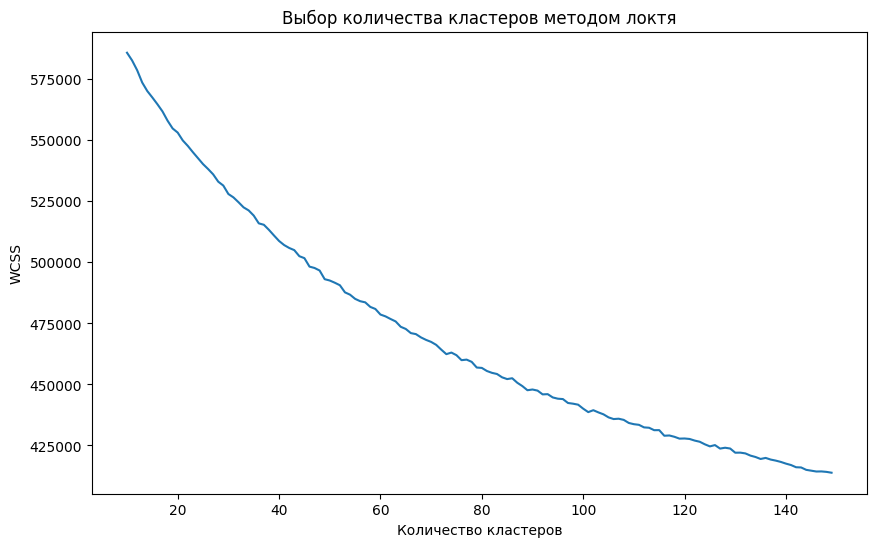

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in tqdm(range(10, 150)):

    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 10, n_init = 50, random_state = 42)
    kmeans.fit(train_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize = (10,6))
plt.plot(range(10, 150), wcss)
plt.title('Выбор количества кластеров методом локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')

По методу локтя я бы сказала, что оптимальное количество кластеров равно 100. Попробуем обучить FAISS с этим количеством кластеров немного ниже.

Поиск ближайших соседей на сырых данных

In [ ]:
def make_score(base, train, t, n_cells=20):
  base_index = {k: v for k, v in enumerate(base.index.to_list())}
  dims = base.shape[1]
  n_cells = 20
  quantizer = faiss.IndexFlatL2(dims)
  idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
  idx_l2.train(np.ascontiguousarray(base.values).astype('float32'))
  idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))
  candidate_number = 5
  r, idx = idx_l2.search(np.ascontiguousarray(train.values).astype('float32'), candidate_number)
  acc = 0
  for target, el in zip(t.values.tolist(), idx.tolist()):
      acc += int(target in [base_index[r] for r in el])
  print(f'Accuracy @ {candidate_number} = {acc / len(idx):.1%}')

In [ ]:
%%time
make_score(base, train, targets)

Accuracy @ 5 = 11.5%
CPU times: user 22.6 s, sys: 474 ms, total: 23.1 s
Wall time: 16.7 s


Скор низкий, так как данные сильно зашумлены и не масштабированы составляет 11,5%

Поиск ближайших соседей только на признаках имеющих нормальное распределение

In [ ]:
%%time
make_score(base_drop_feature, train_drop_feature, targets)

Accuracy @ 5 = 64.7%
CPU times: user 20.3 s, sys: 202 ms, total: 20.5 s
Wall time: 11.4 s


В данных стало явно меньше шума после удаления признаков 6, 21, 25, 33, 44, 59, 65, 70. Результат повышение скора с 11,5 до 64,7%

Взглянем улучшится ли метрика на стандартизированных данных

In [ ]:
%%time
make_score(base_scaled, train_scaled, targets)

Accuracy @ 5 = 68.3%
CPU times: user 21.6 s, sys: 170 ms, total: 21.7 s
Wall time: 13.1 s


После стандартизации данных метрику удалось повысить до 68,3%

Теперь попробуем изменить количество кластеров до 100 на тех же данных.

In [ ]:
def make_score_100(base, train, t, n_cells=100):
  base_index = {k: v for k, v in enumerate(base.index.to_list())}
  dims = base.shape[1]
  n_cells = 100
  quantizer = faiss.IndexFlatL2(dims)
  idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
  idx_l2.train(np.ascontiguousarray(base.values).astype('float32'))
  idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))
  candidate_number = 5
  r, idx = idx_l2.search(np.ascontiguousarray(train.values).astype('float32'), candidate_number)
  acc = 0
  for target, el in zip(t.values.tolist(), idx.tolist()):
      acc += int(target in [base_index[r] for r in el])
  print(f'Accuracy @ {candidate_number} = {acc / len(idx):.1%}')

In [ ]:
%%time
make_score_100(base_scaled, train_scaled, targets)

Accuracy @ 5 = 67.3%
CPU times: user 5.32 s, sys: 92.4 ms, total: 5.42 s
Wall time: 3.02 s


Гипотеза о том, что 100 кластеров повысит скор не подтвердилась, скор остался на том же уровне

Попробуем найти к5 ближайших соседей с помощью расстояния Махалонобиса. Для реализации через Faiss необходимо вычислить матрицу ковариации и обратную матрицу Холецкого, а после загрузить эти данные в метрику L2. Мы будем использовать стандартизированный набор данных

In [ ]:
def make_score_mahalanobis(bases, trains, t, k=5):
  cov_matrix = np.cov(bases.T)
  base_index = {k: v for k, v in enumerate(bases.index.to_list())}

  L = scipy.linalg.cholesky(cov_matrix)
  inv_sqrt_L = scipy.linalg.inv(L)
  whitened_data = np.dot(inv_sqrt_L, bases.T).T
  dimension = whitened_data.shape[1]

  index = faiss.IndexFlatL2(dimension)
  arr_c = whitened_data.copy(order='C')
  index.add(arr_c.astype('float32'))
  D, I = index.search(np.ascontiguousarray(trains).astype('float32'), k)

  acc = 0
  for target, el in zip(t.values.tolist(), I.tolist()):
      acc += int(target in [base_index[D] for D in el])
  print(f'Accuracy @ {k} = {acc / len(I):.1%}')

Accuracy @ 5 = 78.7%
CPU times: user 25.4 s, sys: 494 ms, total: 25.9 s
Wall time: 18.7 s


In [ ]:
%%time
make_score_mahalanobis(base_scaled, train_scaled, targets)

Accuracy @ 5 = 78.7%
CPU times: user 26.2 s, sys: 346 ms, total: 26.6 s
Wall time: 21.3 s


С расстоянием Махалонобиса метрику удалось повысить до 78,7%

**Теперь замерим скор на валидационной выборке**

In [ ]:
%%time
make_score_mahalanobis(base_scaled, validation_scaled, validation_answer.Expected)

Accuracy @ 5 = 78.0%
CPU times: user 24.9 s, sys: 351 ms, total: 25.2 s
Wall time: 17.3 s


На валидационной выборке потеря качества составила всего 0,7%, 78% довольно высокий результат.

**Общий вывод**

Данные хранились в 4 датасетах:
* train состоит из 9999 объектов и 73 признаков
* validation состоит из 10000 объектов и 72 признаков
* base состоит из 291813 объектов и 72 признаков
* validation_answer состоит из 10000 объектов и одного целевого признака - разметки для validation

В ходе работы над задачей поиска ближайших соседей была проведена предобработка данных. Так как данные в исследовании обезличены, предобработка заключалась в
поиске дубликатов, пропущеных значений, отборе признаков и последующем масштабировании с помощью StandardScaler. На основании гистограмм и диаграмм  оставлены для обучения модели признаки с нормальным распределением, остальные удалены.
1. результат на сырых данных скор низкий, так как данные сильно зашумлены и не масштабированы составляет 11,5%;
2. поиск ближайших соседей только на признаках имеющих нормальное распределение: в данных стало явно меньше шума после удаления признаков 6, 21, 25, 33, 44, 59, 65, 70. Результат повышение скора с 11,5 до 64,7%;
3. после стандартизации данных метрику удалось повысить до 68,3%;
4. гипотеза о том, что 100 кластеров повысит скор, основанная на результатах метода локтя не подтвердилась. Скор понизился на 1% по отношению к 20 кластерам и составил 67,3% на стандартизированных данных;

5. далее я для поиска ближайших соседей использовала расстояние Махалонобиса. Для реализации через Faiss вычислила матрицу ковариации и обратную матрицу Холецкого, а после обернула эти данные в метрику L2. На стандартизированном наборе данных с помощью расстояния Махалонобиса метрику удалось повысить до 78,7%.
6. на валидационном датасете расстояние Махалонобиса с FAISS показало скор 78%.
